In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import os

In [14]:
raw = pd.read_csv("10year.csv")

In [38]:
def train_test_valid(file_name,term,valid=True):
    raw = pd.read_csv(f"{file_name}")
    
    # 데이터셋 분할
    from sklearn.model_selection import train_test_split
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(raw.iloc[:,:-1],raw.iloc[:,-1],
                                                       random_state = 1,test_size = 0.3)
    
    if valid:
        X_train,X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.2,
                                                            random_state = 1)

        # 표준화
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        return X_train,X_valid,X_test,y_train,y_valid,y_test
    else:
         # 표준화
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        scaler = StandardScaler().fit(X_train_valid)
        X_train_valid = scaler.transform(X_train_valid)
        X_test = scaler.transform(X_test)
        
        return X_train_valid, X_test, y_train_valid, y_test

In [38]:
# 파라미터 초기화 설정
lucun_init = keras.initializers.VarianceScaling(scale=2.,
                                mode="fan_in",distribution="truncated_normal")

In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
def get_score(X_test, y_test, term,model):
    predicted = model.predict(X_test)[:,-1,:].round()
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test,predicted)
    recall = recall_score(y_test, predicted)
    confusion = confusion_matrix(y_test, predicted)
    roc = roc_auc_score(y_test, predicted)
    return accuracy, precision, recall, confusion, roc

### 클래스 개수의 균형 확인

In [326]:
y_train.value_counts()/y_train.value_counts().sum()

0    0.882135
1    0.117865
Name: CR, dtype: float64

## 년도별 accuracy, recall, precision, roc 비교 -> 10개년의 recall이 가장 좋음

In [40]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("final_rnn_best_model.h5",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [184]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("final_rnn_best_model.h5",
                                               save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

models = []
result = {}
valid = True

# 파일명 읽어오기
data_path = os.path.join(".","final_data")
file_names = ["10year.csv"]

# 하이퍼 파라미터 지정
learning_rate = 1e-3
max_epoch = 40

for idx, file_name in enumerate(file_names):
    # 해당 파일의 년도 추출
    term = int(file_name.split("y")[0])
    
    # 1년도 데이터는 의미가 없기 때문에 rnn 모델을 실시하지 않음
    if term==1:
        continue
        
    print(f"{term}년도 데이터 훈련시작")
    
    # 데이터 분할
    X_train,X_valid,X_test, y_train,y_valid,y_test = train_test_valid(file_name,term, valid=True)
    
    # RNN 데이터 차원에 맞도록 조정
    input_size = X_train.shape[1]//term
    X_train = X_train.reshape(X_train.shape[0], term, input_size)
    X_valid = X_valid.reshape(X_valid.shape[0],term, input_size)
    X_test = X_test.reshape(X_test.shape[0],term,input_size)
    
    # RNN 모델 구현
    model = keras.models.Sequential()
    models.append(model)
    
    # 은닉층 추가
    models[idx].add(keras.layers.SimpleRNN(512, activation = "tanh",return_sequences = True, input_shape =[None,52]))
    models[idx].add(keras.layers.SimpleRNN(512, activation = "tanh",return_sequences = True, input_shape =[None,52]))
    
    # 출력층 추가
    models[idx].add(keras.layers.Dense(1, activation = "sigmoid"))

    # 모델 컴파일
    models[idx].compile(loss="binary_crossentropy", metrics="accuracy", optimizer = keras.optimizers.Adam(lr=learning_rate))
    
    # 모델 훈련
    history = models[idx].fit(x=X_train,y=y_train, epochs = max_epoch, 
                           validation_data = (X_valid,y_valid),
                       class_weight = {0:0.1, 1:0.9}, batch_size = X_train.shape[0],validation_batch_size=X_valid.shape[0],
                             callbacks=[checkpoint_cb, early_stopping_cb])
    
    # 모델 평가
    a={i:j for i,j in zip(["accuracy", "precision", "recall", "confusion", "roc"],get_score(X_test,y_test,term,models[idx]))}
    result[f"{term}year"]=a

10년도 데이터 훈련시작
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1344 - accuracy: 0.5341 - val_loss: 1.1096 - val_accuracy: 0.6006
Epoch 2/40
1/1 [==============================] - 1s 713ms/step - loss: 0.1463 - accuracy: 0.6100 - val_loss: 0.8293 - val_accuracy: 0.6721
Epoch 3/40
1/1 [==============================] - 1s 739ms/step - loss: 0.1188 - accuracy: 0.6652 - val_loss: 0.6900 - val_accuracy: 0.6919
Epoch 4/40
1/1 [==============================] - 1s 751ms/step - loss: 0.1047 - accuracy: 0.6892 - val_loss: 0.6325 - val_accuracy: 0.7062
Epoch 5/40
1/1 [==============================] - 1s 715ms/step - loss: 0.0963 - accuracy: 0.7048 - val_loss: 0.6034 - val_accuracy: 0.7224
Epoch 6/40
1/1 [==============================] - 1s 692ms/step - loss: 0.0905 - accuracy: 0.7210 - val_loss: 0.5850 - val_accuracy: 0.7368
Epoch 7/40
1/1 [==============================] - 1s 704ms/step - loss: 0.0863 - accuracy: 0.7397 - val_loss: 0.5771 - val_accuracy: 0.7479
Epoch 8/4

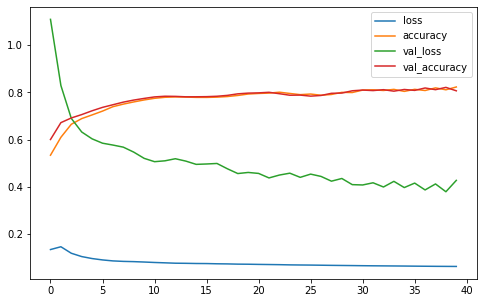

In [185]:
pd.DataFrame(history.history).plot(figsize = (8,5))

In [186]:
final_model = keras.models.load_model("final_rnn_best_model.h5")

In [187]:
accuracy, precision, recall, matrix, roc = get_score(X_test,y_test,10,models[0])
print("accuracy : {:.2}".format(accuracy))
print("precision : {:.2}".format(precision))
print("recall : {:.2}".format(recall))
print("roc : {:.2}".format(roc))
print("confusion-matrics")
print(matrix)

accuracy : 0.78
precision : 0.34
recall : 0.94
roc : 0.85
confusion-matrics
[[2951  941]
 [  30  477]]
